In [164]:
import pandas as pd

#training1 = pd.read_csv('data/subjects/rommel_data/r_word_1/r_word_1_final.csv')
training2 = pd.read_csv('data/subjects/rommel_data/r_word_2/r_word_2_final.csv')
training3 = pd.read_csv('data/subjects/rommel_data/r_word_3/r_word_3_final.csv')
test = pd.read_csv('data/subjects/rommel_data/r_word_1/r_word_1_final.csv')

In [165]:
df = [training2, training3]
training = pd.concat(df, ignore_index=True)
training.dropna(inplace = True) 
training.reset_index(inplace = True)

In [166]:
training.head()

,index,Subject,Date_Time,CH_1_mV,CH_2_mV,CH_3_mV,CH_4_mV,Target
0,0,r_num_2,2019-03-13 19:44:54.802068,0.525094,1.554846,-1.882855,16.836987,relax
1,1,r_num_2,2019-03-13 19:44:54.802268,0.522593,1.559750,-1.885115,16.810854,relax
2,2,r_num_2,2019-03-13 19:44:54.802367,0.516751,1.562130,-1.890380,16.832058,relax
3,3,r_num_2,2019-03-13 19:44:54.803959,0.531705,1.557779,-1.893457,16.817586,relax
4,4,r_num_2,2019-03-13 19:44:54.804153,0.531200,1.548475,-1.888072,16.820062,relax


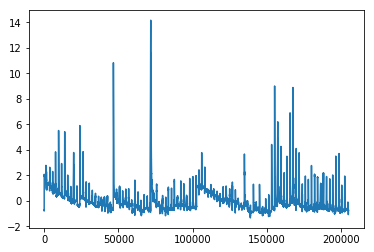

In [167]:
import matplotlib.pyplot as plt
import seaborn as sns

# Right Jaw 
plt.plot('CH_1_mV', data = new_training)
plt.show()

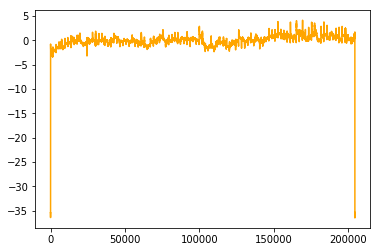

In [168]:
# Left Cheeck
plt.plot('CH_2_mV', data= new_training,  color='orange')
plt.show()

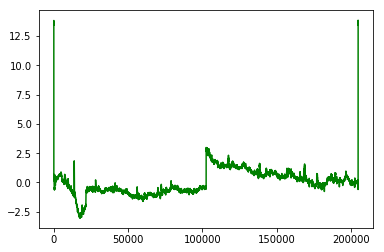

In [169]:
# Throat
plt.plot('CH_3_mV', data= new_training,  color='green')
plt.show()

In [170]:
# Low Pass Signal Applied 

In [171]:
def low_pass(fc, b):
    '''
    :param fc: cutoff frequency
    :param b: bandwidth
    :return: low pass filter
    '''
    N = int(np.ceil((4 / b)))
    if not N % 2: N += 1
    n = np.arange(N)

    sinc_func = np.sinc(2 * fc * (n - (N - 1) / 2.))
    window = 0.42 - 0.5 * np.cos(2 * np.pi * n / (N - 1)) + 0.08 * np.cos(4 * np.pi * n / (N - 1))
    sinc_func = sinc_func * window
    sinc_func = sinc_func / np.sum(sinc_func)
    return sinc_func


In [172]:
import numpy as np

# Create new database after filtering data 

def filtered_data(fc,bw, data):
    lp_filter = low_pass(0.05,0.08)
    cln= {'CH_1_mV': np.convolve(data['CH_1_mV'], lp_filter),
          'CH_2_mV': np.convolve(data['CH_2_mV'], lp_filter),
          'CH_3_mV': np.convolve(data['CH_3_mV'], lp_filter)}
    output = pd.DataFrame(cln)
    diff = len(output)- len(data)
    del_rows = diff/2
    ouput = output.loc[del_rows:len(output)-del_rows-1]
    output.reset_index(inplace = True, drop = True)
    output['Target'] = data['Target']
    return output

def round_up_to_even(f):
    return math.ceil(f / 2.) * 2

new_training =filtered_data(0.05,0.08,training)
new_test = filtered_data(0.05, 0.08, test)

In [173]:
# deterime value ranges for targets 
import more_itertools as mit

def min_max(data, val ='targets'):
    if val == 'targets':
         values = data[data['Target'] != 'relax'].index.tolist()
    else:
         values = data[data['Target'] == 'relax'].index.tolist()
    groups = [list(group) for group in mit.consecutive_groups(values)]
    return groups

groups = min_max(new_training,'targets')

In [174]:
 def create_plots(rows,data):
    '''
    :param rows: rows from ranges of taget values 
    :param data: data frame to use
    :return: plot of sigals
    '''
    plt.figure(figsize=(25,5))

    plt.subplot(1,4,1)
    plt.plot(data['CH_1_mV'][min(rows):max(rows)])

    plt.subplot(1,4,2)
    plt.plot(data['CH_2_mV'][min(rows):max(rows)])

    plt.subplot(1,4,3)
    plt.plot(data['CH_3_mV'][min(rows):max(rows)])
   
    plt.subplot(1,4,4)
    plt.text(0.35, 0.5, data.iloc[min(rows) + 10]['Target'] , dict(size=25))
    
    plt.show()

In [175]:
# Plot Results 
#for rows in groups:
#    create_plots(rows,new_training)

In [176]:
# Find average length of each signal

def max_len(groups):
    avg_len = []
    for val in groups:
       avg_len.append(max(val)-min(val))

    avg = sum(avg_len)/len(avg_len)
    return avg

MAX_LEN = round_up_to_even(max_len(groups))

In [177]:
# Transform data with normaizliation 
def trans_data_train(df):
    for col in df:
        if col not in ['Target']:
            #take the z-score 
            df[col] = (df[col] - df[col].mean())/df[col].std(ddof=0)
            
            
def trans_data_test(df_test, df_train):
    for col in df_test:
        if col not in ['Target']:
            #take the z-score 
            df_test[col] = (df_test[col] - df_train[col].mean())/df_train[col].std(ddof=0)
                       
                       
trans_data_train(new_training)
trans_data_test(new_test, new_training)

In [190]:
def new_cat(row):
    if row == 'relax':
        return 99
    if row == 'no':
        return 0
    else:
        return 1
    
new_test['Target'] = new_test['Target'].apply(new_cat)
new_training['Target'] = new_training['Target'].apply(new_cat)

In [193]:
X_train = [new_training[['CH_1_mV', 'CH_2_mV','CH_3_mV']].values]
y_train = [new_training[['Target']].values]
X_test = [new_test[['CH_1_mV', 'CH_2_mV','CH_3_mV']].values]
y_test = [new_test[['Target']].values]

In [196]:
from keras.preprocessing import sequence
import tensorflow as tf

X_train = sequence.pad_sequences(X_train, dtype ='float32', maxlen = max_length, padding = 'post', truncating = 'post')
y_train = sequence.pad_sequences(y_train, dtype ='float32', maxlen = max_length, padding = 'post', truncating = 'post')
X_test = sequence.pad_sequences(X_test, dtype ='float32', maxlen = max_length, padding = 'post', truncating = 'post')
y_test = sequence.pad_sequences(y_test, dtype ='float32', maxlen = max_length, padding = 'post', truncating = 'post')

array([ -0.71529974, -35.39818732,  13.42910896])

In [ ]:
from keras.layers import LSTM
from keras import optimizers
from keras import layers
from keras import models


model = models.Sequential()
model.add(LSTM(265, input_shape = (None, X_train.shape[-1]), return_sequences=True))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=.001),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(X_train, y_train, epochs=10, batch_size=128, validation_split=0.20)